In [1]:
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
%pip  install -r FastSAM/requirements.txt
# install CLIP
%pip  install git+https://github.com/openai/CLIP.git
# install SAM
%pip  install git+https://github.com/facebookresearch/segment-anything.git
# install other dependencies
%pip  install roboflow supervision jupyter_bbox_widget
%pip install roboflow

fatal: destination path 'FastSAM' already exists and is not an empty directory.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-i997mh54
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-i997mh54
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0jsfrjpc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0jsfrjpc
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="OZmt7veKofDCRjgyQ5XE")
project = rf.workspace("csilab").project("csilab-braintumor")
dataset = project.version(3).download("coco-segmentation")

import os
HOME = os.getcwd()
print("HOME:", HOME)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to CsiLab-BrainTumor-3 in coco-segmentation:: 100%|██████████| 311/311 [00:00<00:00, 1904.07it/s]


HOME: /content


In [3]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!wget -P {HOME}/weights -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


In [4]:
FAST_SAM_CHECKPOINT_PATH = "/content/weights/FastSAM.pt"
SAM_SAM_CHECKPOINT_PATH = "/content/weights/sam_vit_h_4b8939.pth"

In [5]:
%cd {HOME}/FastSAM

import os
import cv2
import torch
import roboflow
import base64

import supervision as sv
import numpy as np

from roboflow import Roboflow
from fastsam import FastSAM, FastSAMPrompt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

/content/FastSAM


In [6]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fast_sam = FastSAM(FAST_SAM_CHECKPOINT_PATH)

In [11]:
IMAGE_PATH = "/content/FastSAM/CsiLab-BrainTumor-3/valid/19_jpg.rf.c1e0be4d1a4762598af6349b6b95e770.jpg"

In [12]:
def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    detections = sv.Detections(xyxy=xyxy, mask=masks)

    mask_annotator = sv.MaskAnnotator()
    return mask_annotator.annotate(scene=image.copy(), detections=detections)

In [17]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.text_prompt(text='circle')


image 1/1 /content/FastSAM/CsiLab-BrainTumor-3/valid/19_jpg.rf.c1e0be4d1a4762598af6349b6b95e770.jpg: 1024x1024 2 objects, 160.3ms
Speed: 6.4ms preprocess, 160.3ms inference, 5.0ms postprocess per image at shape (1, 3, 1024, 1024)


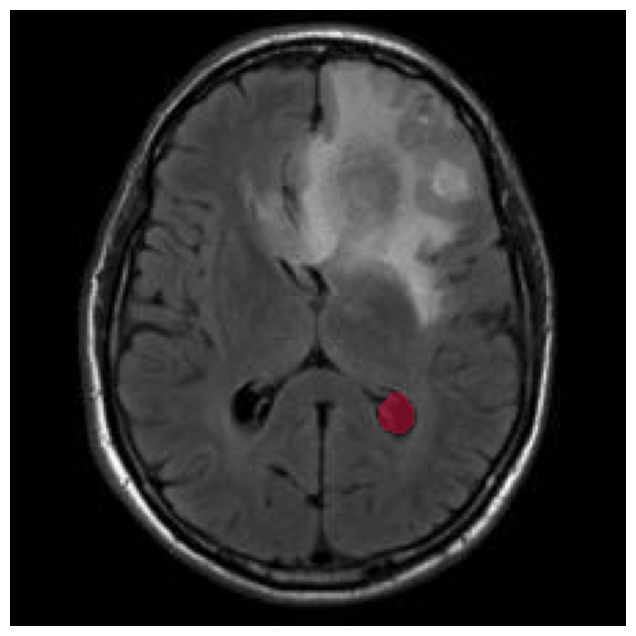

In [18]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))